# Introduction

Ce compte-rendu présente les codes et résultats obtenus au cours du TP réalisé dans le cadre du module d'imagerie médicale. Plus précisemment, on s'intéresse cette fois à l'aspect tomographique du domaine.
Les objectifs du TP sont décris dans la section ci-dessous. A la fin de chaque section, on ajoutera une section "Commentaires" dans laquelle nous commenterons les résultats obtenus.

Ce compte-rendu au format Jupyter Notebook à été réalisé par :

**Raphaël COËZ**\
**Erwan TOUX**\
**Arthur L'HOST**

# Objectifs
Implémenter la rétroprojection filtrée 2D en géométrie parallèle. L'algorithme consiste à rétroprojeter:
$$
f(\vec{x})=\int_0^\pi p^*_\theta(\vec{x}\cdot\vec{u_\theta})\mathrm{d}\theta
$$
les projections filtrées avec un filtre rampe:
$$
p^*_\theta(s) = \int_{-\infty}^\infty \lvert \rho \rvert \hat p_\theta(\rho)e^{2\pi i\rho s}\mathrm{d}\rho
$$
avec $\vec{u_\theta}=(\cos \theta,\sin\theta)$ l'orientation du détecteur et $\hat p_\theta$ la transformée de Fourier 1D de $p_\theta$.

Le dessin ci-dessous ilustre les notations utilisées dans ce notebook:

![parallel_fig.png](parallel_fig.png)

Dans un deuxième temps nous nous intéresserons à un algorithme de reconstruction itératif: Maximum-Likelihood Expectation-Maximization (MLEM). 

Enfin, il s’agira de comparer les temps de calcul et la qualité des différentes reconstructions de chacune des deux méthodes.

# Données
Nous allons travailler sur une coupe du fantôme de Shepp Logan 3D.
Le code utilisé pour produire l'image de `réference` est donné ci-dessous:

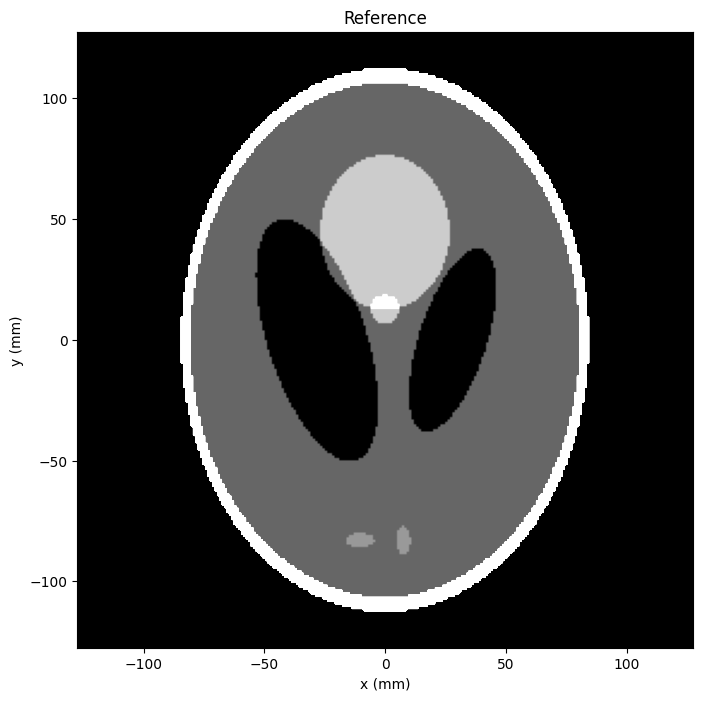

In [147]:
import numpy as np
import itk
from itk import RTK as rtk

# Define the image type, we will use 3D float images in these hands-on sessions
ImageType = itk.Image[itk.F,3]

# Create an image filled with 0 in which we will draw the phantom
srcdraw = rtk.ConstantImageSource[ImageType].New()
srcdraw.SetConstant(0.) # Note that this is useless because 0 is the default
srcdraw.SetSize([256,1,256])
srcdraw.SetSpacing([1,1,1])
srcdraw.SetOrigin([-127.5,0.,-127.5])

# Draw the Shepp Logan in it
sldraw = rtk.DrawSheppLoganFilter[ImageType, ImageType].New()
sldraw.SetInput(srcdraw.GetOutput())
sldraw.SetPhantomScale(128)
sldraw.SetOriginOffset([0.,0.25,0.])
sldraw.InPlaceOff()
sldraw.Update()
itk.imwrite(sldraw.GetOutput(),'ref.mha')
reference = itk.GetArrayFromImage(sldraw.GetOutput()).squeeze()

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
x=np.linspace(srcdraw.GetOrigin()[0],
               srcdraw.GetOrigin()[0]+(srcdraw.GetSize()[0]-1)*srcdraw.GetSpacing()[0],
               num=reference.shape[1])
y=np.linspace(srcdraw.GetOrigin()[2],
               srcdraw.GetOrigin()[2]+(srcdraw.GetSize()[2]-1)*srcdraw.GetSpacing()[2],
               num=reference.shape[0])
plt.imshow(reference, clim=[1,1.05], cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Reference')
plt.show();

et la fonction permettant de calculer les projections est la suivante:

In [148]:
def RadonTransformSheppLogan(thetadeg):
    geometry = rtk.ThreeDCircularProjectionGeometry.New()
    for angle in thetadeg:
        # The convention in the courses is opposite of that of RTK for the rotation angle.
        # We simply use the courses convention and convert the angle to RTK's convention
        geometry.AddProjection(1000,0,-angle)

    # Create an image filled with 0 in which we will draw the phantom
    srcproj = rtk.ConstantImageSource[ImageType].New()
    srcproj.SetSize([reference.shape[1],1,len(thetadeg)])
    srcproj.SetSpacing(srcdraw.GetSpacing())
    srcproj.SetOrigin([srcdraw.GetOrigin()[0],0.,0.])

    # Project the Shepp Logan in it
    slproj = rtk.SheppLoganPhantomFilter[ImageType, ImageType].New()
    slproj.SetInput(srcproj.GetOutput())
    slproj.SetGeometry(geometry)
    slproj.SetPhantomScale(128)
    slproj.SetOriginOffset([0.,0.25,0.])
    slproj.Update()
    sinogram = itk.GetArrayFromImage(slproj.GetOutput()).squeeze()
    s=np.linspace(srcproj.GetOrigin()[0],
              srcproj.GetOrigin()[0]+(srcproj.GetSize()[0]-1)*srcproj.GetSpacing()[0],
              num=srcproj.GetSize()[0])
    return sinogram, s

**Exercice:** Tracer le sinogramme en précisant $N_\theta$, le nombre d'angles choisi dans l'intervalle $[0°,180°[$

In [213]:
def getSinoAndSAndAngles(n_theta_p):
    anglesp = list(np.linspace(0, 180, n_theta_p, endpoint=False))
    sinogrammep, sp = RadonTransformSheppLogan(anglesp)
    return sinogrammep, sp, anglesp

In [150]:
n_theta = 180
sinogramme, s, angles = getSinoAndSAndAngles(n_theta)

# Commentaires

Dans cette première partie, on se contente de prendre connaissance des codes permettant de générer l'image de référence et la fonction de projection.

En outre, on a tracé le sinogramme, c'est-à-dire l'empilement des différentes projections 1D par la transformée de Radon de l'image de référence.

La fonction RadonTransform prend en paramètre une liste d'angle theta définie par nos soins :
Le but est d'envoyer à la fonction un certain nombre N0 d'angles compris entre 0 et 180 degrés exclus.
Le nombre N0 est à déterminer, nous avons choisis arbitrairement d'envoyer 180 angles à la fonction, répartis équitablement sur l'intervalle [0,180[.

On récupère ensuite le sinogramme et on l'affiche grâce à *imshow*, en niveau de gris. Grâce au paramètre *extent*, on définit entre quelles limites le sinogramme est affiché.

On obtient le résultat suivant :

Text(0.5, 1.0, 'Reference')

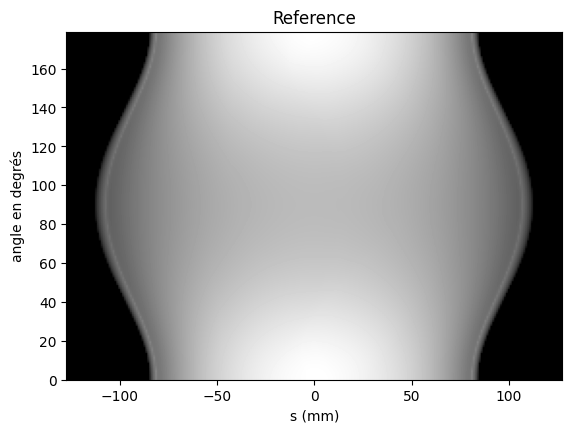

In [151]:
plt.imshow(sinogramme, cmap=plt.cm.gray, extent=(s[0], s[-1], angles[0], angles[-1]), origin="lower")
plt.xlabel('s (mm)')
plt.ylabel('angle en degrés')
plt.title('Reference')

C'est à partir de ce sinogramme que l'on va déterminer et reconstruire notre fantôme de Shepp-Logan. Le sinogramme n'est que l'acquisition de données suivant une coupe dans le domaine de Radon.

# Rétroprojection
On cherche maintenant à inverser la projection, i.e. à passer du domaine de Radon au domaine image.

**Exercice:** Implémenter dans un premier temps la rétroprojection simple de la transformée de Radon:
$$
f(\vec{x})=\int_0^\pi p_\theta(\vec{x}\cdot\vec{u_\theta})\mathrm{d}\theta = \int_0^\pi p_\theta(x cos(\theta)+y sin(\theta))\mathrm{d}\theta
$$
qui après discrétisation donne:
$$
f(x, y)=\Delta \theta \sum_{k=0}^{N_\theta-1} p_{\theta_k}(x cos(\theta_k) + y sin(\theta_k))
$$

Pour l'algorithme de la rétroprojection filtrée, la meilleure solution pour implémenter l'opérateur de rétroprojection est d'utiliser un *pixel-based* rétroprojecteur:
- Calculer les coordonnées 2D de chaque pixel de la fonction discretisée $f$. 
- Regarder où se projette chaque pixel sur chaque projection 1D $p_\theta$.
- Faire une interpolation linéraire des projections à ces posisitions.
- Ajouter la valeur interpolée au pixel.

![pixel-based](pixel_based_backprojection.png)

Vous pouvez utiliser la fonction [numpy.meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) pour obtenir une grille de coordonnées à partir des coordonnées des vecteurs $x$ et $y$ (voir leur définition dans la section Donnée). Utilisez l'option`indexing='xy'` pour être cohérent avec la `réference`. Vous pouvez utiliser [numpy.interp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) pour l'interpolation linéaire.

On retroprojecte donc nos points du sinogramme en appliquant la formule discrétisée de la retroprojection

In [152]:
def retroproj(f_p, sinogrammep, sp, anglesp, xp, yp):
    i=0
    xv, yv = np.meshgrid(xp, yp, indexing='xy')
    f_test = f_p.copy()
    d_theta = (anglesp[1]-anglesp[0])
    for angle in anglesp:
        val = np.interp(xv*np.cos(np.deg2rad(angle))+yv*np.sin(np.deg2rad(angle)), sp, sinogrammep[i,:])
        f_test+=np.deg2rad(d_theta) * val
        i+=1
    return f_test

Le code suivant réalise la rétroprojection simple en utilisant RTK.

In [153]:
def BackprojectionRTK(thetadeg):
    geometry = rtk.ThreeDCircularProjectionGeometry.New()
    theta = np.deg2rad(thetadeg)
    for angle in thetadeg:
        # The convention in the courses is opposite of that of RTK for the rotation angle.
        # We simply use the courses convention and convert the angle to RTK's convention
        geometry.AddProjection(1000,0,-angle)
        
    # Recreate projections with 3 slices to accomodate bilinear interpolation
    srcproj = rtk.ConstantImageSource[ImageType].New()
    srcproj.SetSize([reference.shape[1],3, len(thetadeg)])
    srcproj.SetOrigin([srcdraw.GetOrigin()[0],-1.*srcdraw.GetSpacing()[1],0])
    srcproj.SetSpacing(srcdraw.GetSpacing())
    slproj = rtk.SheppLoganPhantomFilter[ImageType, ImageType].New()
    slproj.SetInput(srcproj.GetOutput())
    slproj.SetGeometry(geometry)
    slproj.SetPhantomScale(128)
    slproj.SetOriginOffset([0.,0.25,0.])
    slproj.Update()

    # Backproject
    rtkbp = rtk.BackProjectionImageFilter[ImageType, ImageType].New()
    rtkbp.SetInput(0,srcdraw.GetOutput())
    rtkbp.SetInput(1,slproj.GetOutput())
    rtkbp.SetGeometry(geometry)
    rtkbp.Update()
    rtkbp = itk.GetArrayFromImage(rtkbp).squeeze()
    rtkbp *= np.abs(theta[1]-theta[0])
    
    return rtkbp

**Exercice:** Valider votre rétroprojection en la comparant à celle de RTK. La méthode de rétroprojection simple est-elle satisfaisante ? Expliquer pourquoi.

In [154]:
f = np.zeros_like(reference)
f = retroproj(f, sinogramme, s, angles, x, y)

# Commentaires

Dans cette section, nous avons implémenté une méthode de rétroprojection de la transformée de Radon, méthode fournie en énoncée. Le but était d'évaluer la pertinence de cette méthode notamment en la comparant avec la fonction fournie par RTK permettant d'obtenir théoriquement un résultat équivalent.

En suivant la méthode décrite dans l'énoncé, on obtient le résultat suivant pour la rétroprojection :

Rétroprojection codée :

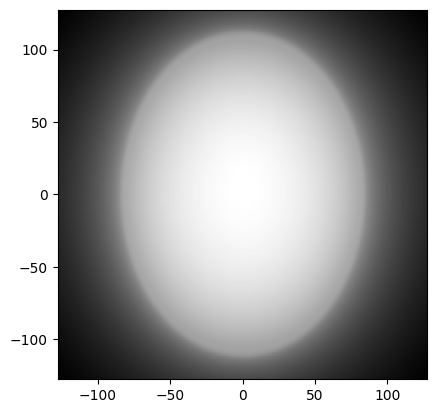

In [155]:
plt.figure()
plt.imshow(f, cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')

Rétroprojection RTK :

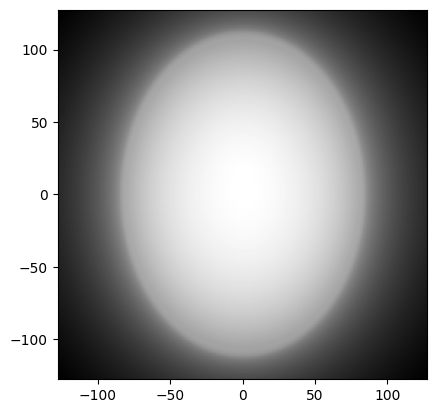

In [156]:
rtkbp = BackprojectionRTK(angles)
plt.figure()
plt.imshow(rtkbp, cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')

Différence :

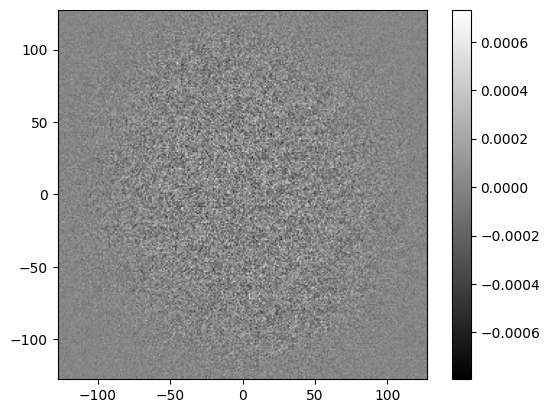

In [157]:
diff = f - rtkbp
plt.figure()
plt.imshow(diff, cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')
plt.colorbar()


Ainsi la rétroprojection vers le domaine image est fonctionnelle, la fonction de RTK étant assez similaire à notre codage de la retroprojection. Cependant le résultat observé n'est pas le résultat attendu. En effet, on observe simplement la forme extérieure du fantôme de Shepp Logan, les détails interne ne sont pas observable. Dans le domaine médical, il s'agirait donc de résultats inexploitables. Cela provient du fait que l'on observe un ensemble de projection sans prendre en compte la physique derrière ces acquisitions. En effet, les rayons émis par les tissus corporels afin d'être observés sur les capteurs ont eux-mêmes été atténués. Ainsi les résultats obtenus sur le sinogramme sont le fruit d'une absorption par les tissus corporel. Ainsi il est nécessaire d'appliquer un filtre sur les fréquences spatiales des signaux émis afin de compenser cette atténuation.

# Filtre Rampe
La version analytique du filtre rampe $\hat h(\rho)=|\rho|$ n'est pas utilisable dans notre cas du fait que les signaux numériques possèdent un spectre limité. Le filtre s'exprime donc par: 
$$
\hat h_\mathrm{BL}(\rho)=\left\{
\begin{array}{ll}%
\lvert \rho \rvert &\mathrm{si}\ \lvert \rho \rvert <\rho\\
0 & \mathrm{sinon,}\\
\end{array}
\right.
$$
où $\rho=1/2\Delta_s$ est la frèquence maximum respectant la condition de Nyquist-Shannon pour un signal échantillonée à $\Delta_s$. Il existe plusieurs implémentations du filtre rampe verifiant cette condition, une des plus communes est: 
$$
h_\mathrm{BL}(s)=\dfrac{1}{2\Delta_s^2}\dfrac{\sin 2\pi s/2\Delta_s}{2\pi s/2\Delta_s}-\dfrac{1}{4\Delta_s^2}\left(\dfrac{\sin\pi s/2\Delta_s}{\pi s/2\Delta_s}\right)^2
$$
qui après discrétisation donne:
$$
h_\mathrm{BL}(n\Delta_s)=
\begin{cases}
\dfrac{1}{4\Delta_s^2} &\mathrm{si}\ n=0,\\
0 &\mathrm{si}\ n\ \mathrm{est\ pair},\\
-\dfrac{1}{\left(n\pi \Delta_s\right)^2} &\mathrm{si}\ n\ \mathrm{est\ impair}.\\
\end{cases}
$$

Le code suivant retourne ce filtre à la fois dans le domaine spatial et fréquentiel:

In [158]:
def RampFilterBL(s, zeropad=2):
    rampbl = np.zeros(s.size*zeropad)
    ds=s[1]-s[0]
    rampbl[s.size*zeropad//2-1]=1/(4*ds**2)
    idxodd = np.concatenate((np.flip(-1*np.arange(1,rampbl.size//2,2)),np.arange(1,rampbl.size//2,2)))
    rampbl[0::2]=-1/(idxodd*np.pi*ds)**2
    rampbl*=ds
    rampbl_fft = np.absolute(np.fft.rfft(rampbl))
    
    return rampbl, rampbl_fft

**Exercice:** En utlisant la fonction précédente, implémentez la rétroprojection filtrée. Vous pouvez utiliser la fonction [numpy.fft.irfft](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.irfft.html) pour la transformée de Fourier 1D inverse, et [numpy.fft.rfftfreq](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfftfreq.html) pour récupérer l'échantillonage des fréquences dans le domaine de Fourier.
Comparer l'image reconstruite avec la référence (vous pourrez notamment afficher un profil). Expliquer l'intérêt et l'effet du filtre rampe lors de la rétroprojection.

In [159]:
def Retroproj_filtree(sp, sinogrammep, referencep, anglesp, xp, yp):
    filtre_ramp, filtre_ramp_fft = RampFilterBL(sp, zeropad=2)
    sinogramme_fft = np.fft.rfft(sinogrammep, n=2*sinogrammep.shape[1] ,axis=1)
    sinogramme_fft_filtre = sinogramme_fft*filtre_ramp_fft
    fft_inv_sinogramme_filtre = np.fft.irfft(sinogramme_fft_filtre)[:, :sinogrammep.shape[1]]

    xv, yv = np.meshgrid(xp, yp, indexing='xy')

    f_1 = np.zeros_like(referencep)
    f_1 = retroproj(f_1, fft_inv_sinogramme_filtre, sp, anglesp, xp, yp)
    return f_1

In [160]:
f_retroproj_filtre = Retroproj_filtree(s, sinogramme, reference, angles, x, y)

Comme dit précédemment les tissus corporels atténuent plus ou moins fortement les rayons émis, ainsi les données acquises sont dépendantes de ces variations d'absorption entre les différents tissus. Un moyen de s'affranchir de cet inconvénient et d'obtenir une image de meilleure qualité est d'utiliser un filtre rampe. On applique ce filtre rampe (amplification des hautes fréquences et réduction des basses fréquences) sur la transformée de fourier 1D de chaque ligne de notre sinogramme. Cela a pour conséquence d'amplifier le niveau de détails de nos projections, pour noter les différences de morphologie de notre image observée.

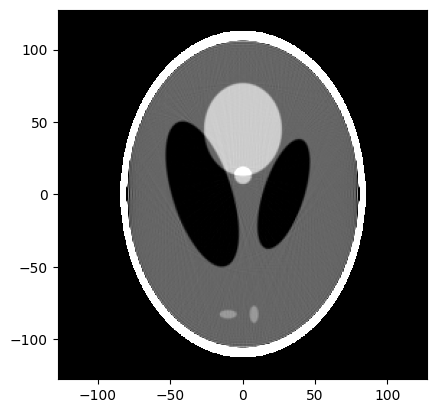

In [161]:
plt.imshow(f_retroproj_filtre, clim=[1,1.05], cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')

**Exercice:** Comparer les qualités d'images reconstruites, les PSNR obtenus et le temps de reconstruction en fonction de $N_\theta$. Pour mesurer le temps de calcul vous pouvez utiliser la fonction [time.time()](https://docs.python.org/3/library/time.html).

Rappel: $\mathrm{PSNR}= 10 \log_{10}(\frac{\mathrm{MAX}^2_I}{\mathrm{MSE}})$

N'oubliez pas de normalier vos images avant de quantifier leur différence.

In [162]:
reference_norm = reference / reference.max()

In [163]:
def Calc_PSNR(f_norm, ref_norm):
    MAX_squared = 1
    MSE = (np.linalg.norm((f_norm-ref_norm))/(np.shape(ref_norm)[0]*np.shape(ref_norm)[1]))**2
    valRen = 10 * np.log10(MAX_squared/MSE)
    return valRen

In [164]:
import time

In [165]:
liste_PSNR = []
liste_ntheta = []
liste_temps = []
n_theta_base = 180

for i in range(1, 100, 10):
    time_start = time.process_time()
    sinogramme, s, angles = getSinoAndSAndAngles(i*n_theta_base)
    f_retroproj_filtre = Retroproj_filtree(s, sinogramme, reference, angles, x, y)
    f_retroproj_filtre_norm = f_retroproj_filtre / f_retroproj_filtre.max()
    PSNR = Calc_PSNR(f_retroproj_filtre_norm, reference_norm)
    time_end = time.process_time()
    liste_PSNR.append(PSNR)
    liste_ntheta.append(i*n_theta_base)
    liste_temps.append(time_end-time_start)

Text(0.5, 1.0, "PSNR en fonction du nombre d'angles acquis")

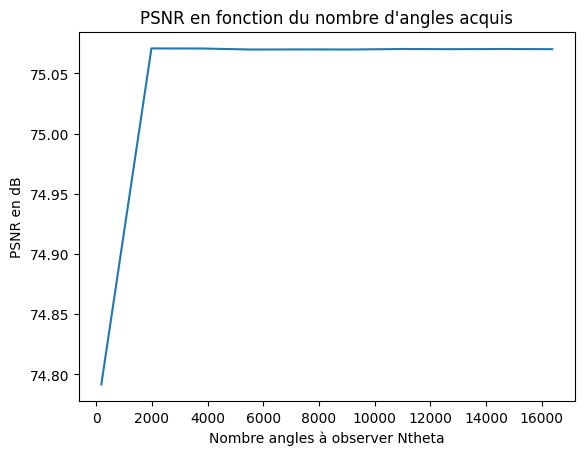

In [166]:
plt.figure()
plt.plot(liste_ntheta, liste_PSNR)
plt.xlabel('Nombre angles à observer Ntheta')
plt.ylabel('PSNR en dB')
plt.title("PSNR en fonction du nombre d'angles acquis")

Text(0.5, 1.0, "Temps de reconstruction en fonction du nombre d'angles")

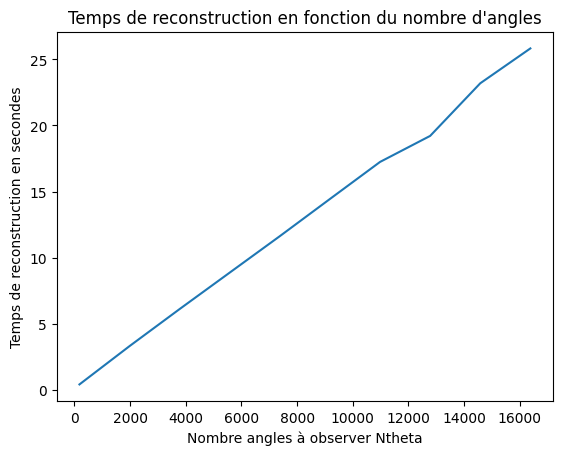

In [167]:
plt.figure()
plt.plot(liste_ntheta, liste_temps)
plt.xlabel('Nombre angles à observer Ntheta')
plt.ylabel('Temps de reconstruction en secondes')
plt.title("Temps de reconstruction en fonction du nombre d'angles")

Une des conséquences de l'utilisation de ce filtre rampe est l'amplification importante du bruit dans notre reconstruction. Les acquisitions n'étant pas parfaite en réalité, il s'agit d'une contrainte assez forte sur l'utilisation du filtre rampe seul.

**Exercice:** Rajouter un bruit additif Gaussien de moyenne nulle au sinogramme de départ en utilisant la fonction [np.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html). Pour un $N_\theta$ fixé, tracez l’évolution du PSNR en fonction de la variance du bruit.

In [168]:
sinogramme, s, angles = getSinoAndSAndAngles(n_theta)
ecart_type = 0.25
list_ecart_type = []
list_PSNR_bruit = list()
list_retroproj = []
for i in range(1, 8):
    ecart_type *= 2
    list_ecart_type.append(ecart_type)
    bruit = np.random.normal(loc=0, scale=ecart_type, size=np.shape(sinogramme))
    sino = sinogramme + bruit
    f_retroproj_filtre = Retroproj_filtree(s, sino, reference, angles, x, y)
    list_retroproj.append(f_retroproj_filtre)
    f_retroproj_filtre_norm = f_retroproj_filtre / f_retroproj_filtre.max()
    PSNR = Calc_PSNR(f_retroproj_filtre_norm, reference_norm)
    list_PSNR_bruit.append(PSNR)

Text(0.5, 1.0, "PSNR en fonction de l'écart type du bruit gaussien à l'acquisition")

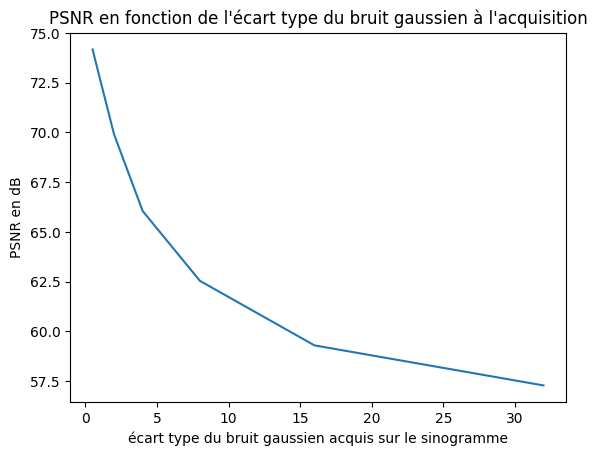

In [169]:
plt.figure()
plt.plot(list_ecart_type, list_PSNR_bruit)
plt.xlabel('écart type du bruit gaussien acquis sur le sinogramme')
plt.ylabel('PSNR en dB')
plt.title("PSNR en fonction de l'écart type du bruit gaussien à l'acquisition")

Comme prévu, l'influence du bruit gaussien est largement amplifié par le fonctionnement du filtre rampe ce qui induit un PSNR plus faible et donc une image reconstruite de mauvaise qualité. Les figures suivantes affichent cette reconstruction, pour différents écarts types.

Ecart type de 0.5 :

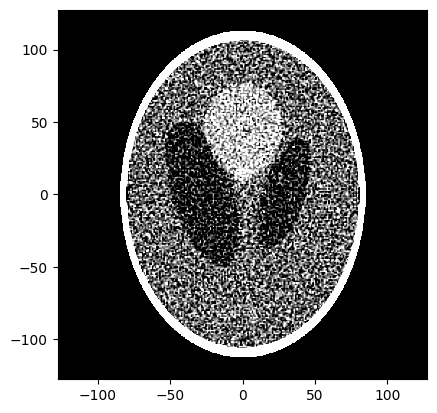

In [170]:
plt.imshow(list_retroproj[0], clim=[1,1.05], cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')

Ecart type de 32 :

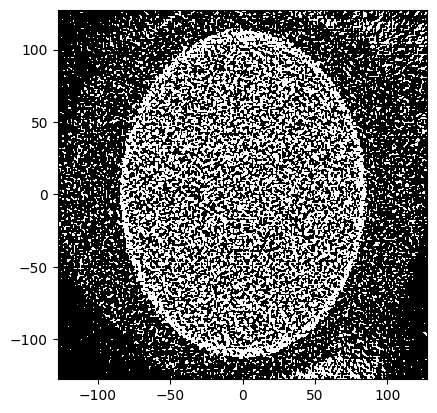

In [171]:
plt.imshow(list_retroproj[-1], clim=[1,1.05], cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')

Une réponse à cette importante influence du bruit dans la reconstruction est l'utilisation du filtre de Hann plutôt que du filtre rampe. Il s'agit d'ajouter une fenêtre d'apodisation au filtre rampe pour ne pas trop amplifier les hautes fréquences qui sont souvent synonymes de bruit.

# Bonus (si vous avez le temps)
Nous avons vu dans le cours que le filtre rampe favorise l'amplification des hautes fréquences et peut introduire du bruit dans l'image reconstruite. Une solution est d'appliquer un filtre passe-bas appelé fenêtre d'apodisation pour atténuer les hautes-fréquences. Le filtre de Hann est couramment utilisé à cet effet:
$$
\hat w(\sigma)=\left\{
\begin{array}{ll}%
0.5*(1+\cos(\frac{\pi \rho}{\rho})) &\mathrm{si}\ \rho <\rho\\
0 & \mathrm{sinon}\\
\end{array}
\right.
$$

**Exercice:** Ajouter le filtre de Hann à votre rétroprojection filtrée et comparer les résultats obtenue pour différentes fréquences de coupure.

(180, 257)
(257,)
(180, 257)


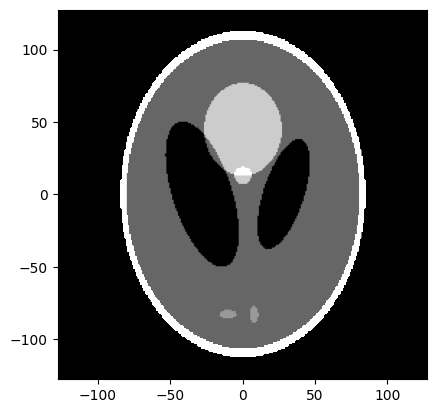

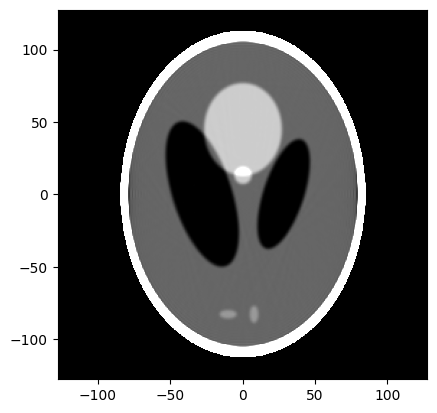

In [172]:
from math import pi
sinogramme, s, angles = getSinoAndSAndAngles(n_theta)

sino_freq = np.fft.rfft(sinogramme ,n = 2 * sinogramme.shape[1], axis = 1)
rampbl, rampbl_fft = RampFilterBL(s, zeropad= 2)
freq = np.fft.rfftfreq(n=2*256)
sino_filtered = rampbl_fft * sino_freq
# reco = np.fft.irfft(sino_filtered, n = sinogram.shape[1])
filter = np.zeros(257)
coupure = 0.45
for i in range(freq.shape[0]):
    filter[i] = 0.5 * (1 + np.cos(pi*freq[i]/coupure))
sino_filtered = np.multiply(rampbl_fft, filter) * sino_freq
reco = np.fft.irfft(sino_filtered)[:,:sinogramme.shape[1]]
print(sino_filtered.shape)
print(rampbl_fft.shape)
print(sino_freq.shape)

X,Y = np.meshgrid(x,y, indexing = 'xy')
f = np.zeros_like(reference)

for theta in angles:
    theta = int(theta)
    theta_rad = np.deg2rad(theta)
    val = (X*np.cos(theta_rad) + Y*np.sin(theta_rad))
    inter = np.interp(val, s, reco[theta])
    f += np.deg2rad(1) * inter

plt.imshow(f, cmap = plt.cm.gray, extent = (x[0], x[-1], y[0], y[-1]), origin = 'lower')

plt.figure(1)
plt.imshow(reference, clim=[1,1.05],  cmap = plt.cm.gray, extent = (x[0], x[-1], y[0], y[-1]), origin = 'lower')
plt.figure(2)
plt.imshow(f, clim = [1, 1.05], cmap = plt.cm.gray, extent = (x[0], x[-1], y[0], y[-1]), origin = 'lower')


# MLEM
Nous supposons que l'émission des photons suit une distribution de Poisson, alors, si $\vec{f}$ représente le vecteur image $\vec{f} = (f_i,..,f_n)^t$ et $\vec{p} = (p_1,..,p_m)^t$ les projections mesurées, la fonction de vraisemblance, qui est la probabilité d'obtenir $\vec{p}$ si l'image est $\vec{f}$, est:
$$
			P_L(\vec{p}/\vec{f}) = \prod_{i=1}^m \frac{\sum_{j=1}^n (r_{ij}f_j)^{p_i}}{p_i!} \exp(-\sum_{j=1}^n r_{ij}f_j)
$$
où $r_{ij}$ représente la probabilité qu'un photon émis par le voxel j soit détecté par le pixel i et $\sum_{i=1}^m r_{ij} = 1$. 

Afin d'estimer $\vec{f}$ à partir de $\vec{p}$, une approche possible est de maximiser $P_L(\vec{p}/\vec{f})$ ou de façon équivalente:
$$
			\max_{\vec{f}\ge0}L(\vec{f})=\sum_{i=1}^m (p_i \ln(\sum_{j=1}^n r_{ij}f_j) - \sum_{j=1}^n r_{ij}f_j)
$$

L'algorithme MLEM cherche une solution qui maximise cette fonction de vraisemblance entre les projections mesurées et les projections de l'image. L'équation de mise à jour est:
$$
			f^{next}_{j} = \frac{f^{current}_{j}}{{\sum_{i} r_{ij}}} {\sum_{i} r_{ij}} \frac{{p_{i}}}{{{\sum_{j} r_{ij}}}f^{current}_{j}}
$$
où $\sum_{i} r_{ij}$ représente l'opérateur de rétroprojection et $\sum_{j} r_{ij}$ l'opérateur de projection.

Une implémentation d'un opérateur de projection est donnée par la fonction suivante:

In [173]:
def ForwardProjectionRTK(volume, thetadeg):
    geometry = rtk.ThreeDCircularProjectionGeometry.New()
    for angle in thetadeg:
        # The convention in the courses is opposite of that of RTK for the rotation angle.
        # We simply use the courses convention and convert the angle to RTK's convention
        geometry.AddProjection(1000,0,-angle)
    
    # Create an image filled with 0 in which we write the projections
    srcproj = rtk.ConstantImageSource[ImageType].New()
    srcproj.SetSize([reference.shape[1],1,len(thetadeg)])
    srcproj.SetSpacing(srcdraw.GetSpacing())
    srcproj.SetOrigin([srcdraw.GetOrigin()[0],0,0.])
    srcproj.Update()
    
    volume = volume[:, np.newaxis, :]
    volume = np.append(volume, np.zeros((volume.shape[0],2,volume.shape[2])), axis=1)
    itkVolume = itk.GetImageFromArray(volume.astype(np.float32))
    itkVolume.SetSpacing([1,1,1])
    itkVolume.SetOrigin([-127.5,0.,-127.5])

    jfp = rtk.JosephForwardProjectionImageFilter[ImageType, ImageType].New()
    jfp.SetInput(0, srcproj.GetOutput())
    jfp.SetInput(1, itkVolume)
    jfp.SetGeometry(geometry)
    jfp.Update()
    jfp = itk.GetArrayFromImage(jfp.GetOutput()).squeeze()
    
    return jfp  

**Exercice:** En utilisant le projecteur implémenté ci-dessus et votre rétroprojecteur, créer une fonction réalisant la reconstruction par la méthode MLEM.

Dans un premier temps, le nombre d'itération sera fixé.

In [174]:
def FonctionDeCout(sinogrammep, proj_estimee):
    valRen = 0
    for i in range(np.shape(sinogrammep)[0]):
        valRen += sinogrammep[i,:] * np.log(proj_estimee[i,:]+ 1e-6) - proj_estimee[i,:]
    return valRen

In [175]:
def CalcMSE(fp, reference_norm):
    f_copy = fp.copy()
    f_copy = f_copy/f_copy.max()
    MSE = (np.linalg.norm((f_copy-reference_norm))/(np.shape(reference_norm)[0]*np.shape(reference_norm)[1]))**2
    return MSE

In [217]:
def MLEM_shepp_logan(n_iterations, anglesp, sinogramme_p, s_p):   
    f_mlem = np.ones_like(reference)
    sino_un = np.ones_like(sinogramme_p)
    f_retro_base = retroproj(f_mlem, sino_un, s_p, anglesp, x, y)

    f_cout=[]
    list_MSE=[]

    for i in range(n_iterations):
        p_chap = ForwardProjectionRTK(f_mlem, anglesp)
        erreur_projection = np.divide(sinogramme_p, p_chap, where=p_chap!=0, out=np.zeros_like(sinogramme_p))
        f_retro = np.ones_like(reference)
        f_corr = retroproj(f_retro, erreur_projection, s_p, anglesp, x, y)
        f_corr_1 = np.divide(f_corr, f_retro_base, where=f_retro_base!=0, out=np.zeros_like(reference))
        f_mlem *= f_corr_1
        list_MSE.append(CalcMSE(f_mlem, reference_norm))
        f_cout.append(np.linalg.norm(FonctionDeCout(sinogramme_p, p_chap)))
    return f_mlem, f_cout, list_MSE

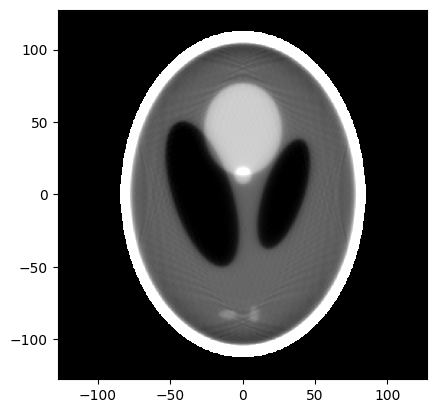

In [203]:
N_iter = 50

sinogram, s = RadonTransformSheppLogan(angles)

f_mlem, f_cout, list_MSE = MLEM_shepp_logan(N_iter, angles, sinogram, s)
plt.imshow(f_mlem, clim=[1, 1.05], cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')

**Exercice:** Vérifier que l'algorithme MLEM maximise bien la fonction de coût en traçant sont évolution en fonction du nombre d'itérations. Tracer aussi l'évolution de l'érreur quadratique moyenne pour vérifier que le volume reconstruit se rapproche bien de la référence.

En déduire un critère de convergence de l'algorithme plus pertinent qu'un nombre fixé d'itérations.

Text(0.5, 1.0, 'Evolution valeur fonction de coût en fonction des itérations')

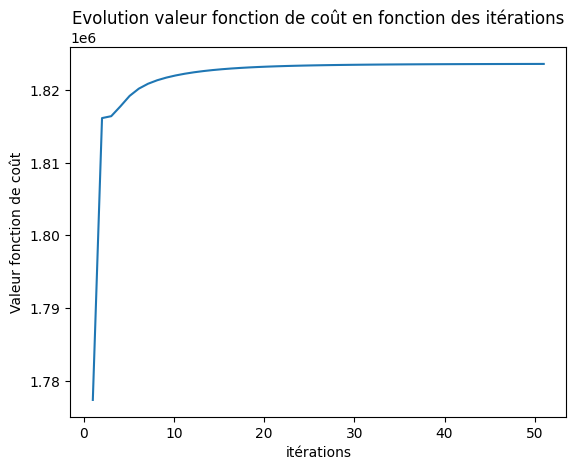

In [178]:
plt.figure()
plt.plot(np.linspace(1, N_iter+1), f_cout)
plt.xlabel('itérations')
plt.ylabel('Valeur fonction de coût')
plt.title("Evolution valeur fonction de coût en fonction des itérations")

Text(0.5, 1.0, "Evolution MSE en fonction du nombre d'itérations")

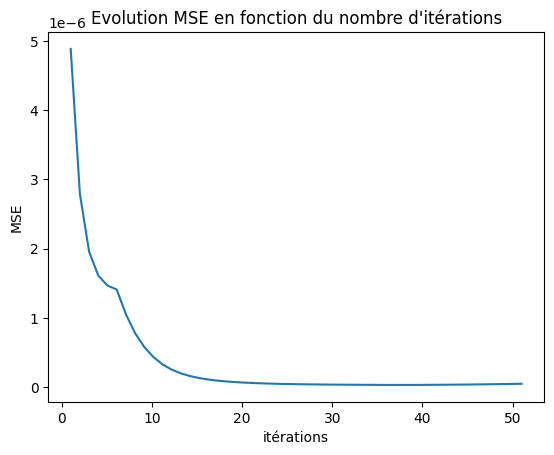

In [179]:
plt.figure()
plt.plot(np.linspace(1, N_iter+1), list_MSE)
plt.xlabel('itérations')
plt.ylabel('MSE')
plt.title("Evolution MSE en fonction du nombre d'itérations")

# Bilan
**Exercice:** En fixant les mêmes paramètres (bruit, taille de l’image, nombre de projections) comparer les reconstructions obtenues (PSNR, temps de calcul, perception visuelle) par les deux méthodes implémentées.

On fixe un bruit gaussien d'écart type de 2 et de moyenne nulle. On décide de prendre 180 angles en 0 et 180 degrés, donc 180 projections. L'image utilisée reste la même : le fantôme de Shepp Logan. Pour l'algorithme de MLEM on prendra 50 itérations. On travaille bien entre 0 et 255 d'où les lignes de code qui forcent le sinogramme à rester entre ces valeurs.

Text(0.5, 1.0, 'Sinogramme')

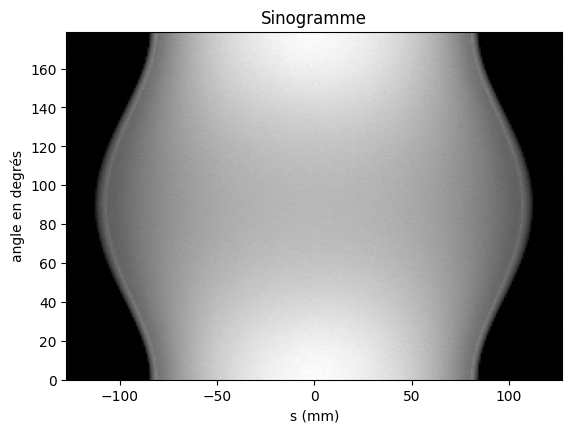

In [219]:
n_theta_final = 360
sino_f, s_f, angles_f = getSinoAndSAndAngles(n_theta_final)
bruit = np.random.normal(loc=0, scale=2, size=np.shape(sino_f))
sino_f = sino_f + bruit
sino_f[sino_f<=0] = 0
sino_f[sino_f>=255] = 255
plt.imshow(sino_f, cmap=plt.cm.gray, extent=(s[0], s[-1], angles[0], angles[-1]), origin="lower")
plt.xlabel('s (mm)')
plt.ylabel('angle en degrés')
plt.title('Sinogramme')

Le PSNR pour la rétroprojection avec filtre rampe est de : 71.99913360518183 dB
Le temps de reconstruction est de : 0.5674355270002707 secondes


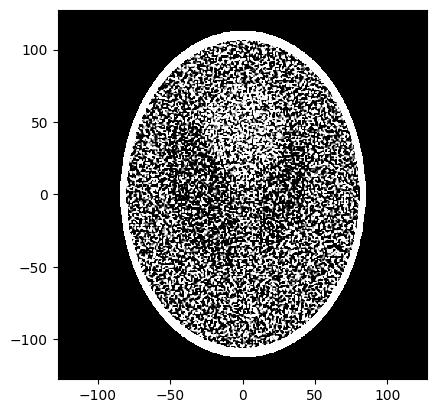

In [220]:
start_time_retroproj_filtree = time.process_time()

f_retroproj_filtre_fin = Retroproj_filtree(s_f, sino_f, reference, angles_f, x, y)
f_retroproj_filtre_fin_norm = f_retroproj_filtre_fin/f_retroproj_filtre_fin.max()

end_time_retroproj = time.process_time()
time_total_retroproj = end_time_retroproj - start_time_retroproj_filtree

PSNR_retroproj_filtree = Calc_PSNR(f_retroproj_filtre_fin_norm, reference_norm)
print(f"Le PSNR pour la rétroprojection avec filtre rampe est de : {PSNR_retroproj_filtree} dB")
print(f"Le temps de reconstruction est de : {time_total_retroproj} secondes")
plt.imshow(f_retroproj_filtre_fin, clim=[1,1.05], cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')

Le PSNR pour la méthode MLEM est de : 56.52061868736638 dB
Le temps de reconstruction est de : 51.58365353999989 secondes


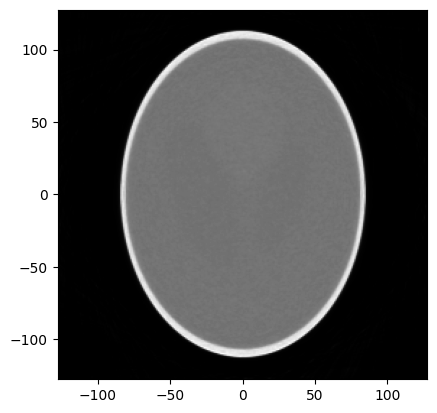

In [221]:
N_iter = 50

start_time_MLEM = time.process_time()

f_mlem, f_cout, list_MSE = MLEM_shepp_logan(N_iter, angles_f, sino_f, s_f)

end_time_MLEM = time.process_time()
time_total_MLEM = end_time_MLEM - start_time_MLEM

PSNR_MLEM = Calc_PSNR(f_mlem, reference_norm)
print(f"Le PSNR pour la méthode MLEM est de : {PSNR_MLEM} dB")
print(f"Le temps de reconstruction est de : {time_total_MLEM} secondes")
plt.imshow(f_mlem, cmap=plt.cm.gray, extent=(x[0],x[-1],y[0],y[-1]), origin='lower')

On peut alors avec les résultats ci-dessus comparer aisément les méthodes. On observe alors une première différence visuelle. La retroprojection montre une trop importante sensibilité au bruit là où la méthode MLEM semble plus tenace mais où les formes internes du fantôme sont difficiles à distinguer. On sait également que plus le PSNR est élevé plus l'image est proche de la réalité et du résultat attendu. Ainsi, la première méthode l'emporte, comme sur le temps de reconstruction.